In [0]:
import pickle
import boto3
import pandas as pd
import numpy as np
# import tensorflow as tf
# from transformers import RobertaTokenizer, TFRobertaModel, AlbertTokenizerFast, AlbertModel

In [0]:
from pyspark.sql import SparkSession
sc = spark.sparkContext
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, StringType, FloatType, ArrayType, DoubleType, StructType, StructField
sqlContext = SQLContext(sc)

In [0]:
base_save_path = "s3://mag-model-data/raw_mag_data/"
iteration_save_path = "s3://mag-model-data/iteration_1/"

## First Data Pull

In [0]:
df = spark.read \
.format("com.databricks.spark.redshift") \
.option("url", redshift_url) \
.option("user", "app_user") \
.option("password", redshift_password) \
.option("query", "select count(*) from mag_main_papers") \
.option("tempdir", base_save_path) \
.option("forward_spark_s3_credentials", True) \
.load()

In [0]:
df.show()

+---------+
 count|
+---------+
259669559|
+---------+

## Getting all data

In [0]:
journal_join_query = \
"""
SELECT paper_id, doc_type, paper_title, journal_name, publication_date, listagg(topic_name, '|') topics
FROM (
SELECT  a.paper_id, a.doc_type, a.paper_title, a.year, 
        a.publication_date, b.normalized_name as journal_name,
        d.normalized_name as topic_name, d.level
FROM (SELECT paper_id, doc_type, paper_title, book_title, year, 
             publication_date, online_date, journal_id
      FROM mag_main_papers) a
LEFT JOIN (SELECT journal_id, normalized_name
           FROM mag_main_journals) b
ON a.journal_id=b.journal_id
LEFT JOIN (SELECT *
           FROM mag_advanced_paper_fields_of_study) c
ON a.paper_id=c.paper_id
LEFT JOIN (SELECT *
           FROM mag_advanced_fields_of_study) d
ON c.field_of_study=d.field_of_study_id )
WHERE topic_name IS NOT NULL
GROUP BY paper_id, doc_type, paper_title, journal_name, publication_date
"""

In [0]:
all_data = spark.read \
.format("com.databricks.spark.redshift") \
.option("url", redshift_url) \
.option("user", "app_user") \
.option("password", redshift_password) \
.option("query", journal_join_query) \
.option("tempdir", base_save_path) \
.option("forward_spark_s3_credentials", True) \
.load()

In [0]:
all_data.printSchema()

root
-- paper_id: long (nullable = false)
-- doc_type: string (nullable = true)
-- paper_title: string (nullable = true)
-- journal_name: string (nullable = true)
-- publication_date: string (nullable = true)
-- topics: string (nullable = true)

In [0]:
all_data.show(5)

+----------+--------+--------------------+--------------------+----------------+--------------------+
 paper_id|doc_type| paper_title| journal_name|publication_date| topics|
+----------+--------+--------------------+--------------------+----------------+--------------------+
1838707898| null|the reform of soc...| null| 2012-01-01|unemployment|labo...|
1963886025| Journal|faits cliniques o...|acta oto laryngol...| 1934-01-01| medicine|
1964360870| Journal|nonlinear adjustm...|applied economics...| 2010-04-14|financial economi...|
1984180625| Journal|safety of dobutam...|journal of the am...| 2005-11-15|food and drug adm...|
1988180879| Journal|application of a ...|journal of experi...| 2004-01-07|biology|bivalvia|...|
+----------+--------+--------------------+--------------------+----------------+--------------------+
only showing top 5 rows

In [0]:
filtered_data = all_data \
.select('paper_id','doc_type','paper_title','journal_name',
        F.to_date(F.col('publication_date'), 'yyyy-MM-dd').alias('publication_date'), 
        F.split(F.col('topics'), "\|").alias('topics')) \
.filter(F.col('publication_date') > "1950-01-01") \
.filter(F.col('publication_date') < "2021-06-01")

In [0]:
filtered_test_data = all_data \
.select('paper_id','doc_type','paper_title','journal_name',
        F.to_date(F.col('publication_date'), 'yyyy-MM-dd').alias('publication_date'), 
        F.split(F.col('topics'), "\|").alias('topics'))  \
.filter(F.col('publication_date') >= "2021-06-01") \
.filter(F.col('publication_date') < "2021-10-01")

In [0]:
filtered_data.cache().count()

Out[31]: 198532356

In [0]:
filtered_test_data.cache().count()

Out[32]: 51537

## Get Train/Val/Test

The following cell will only need to be run once

In [0]:
def split_into_train_val_test(data, test_data, save_path):
    train, val, test = data.randomSplit([0.995, 0.0045, 0.0005])
    
    train.write.mode('overwrite').parquet(f"{save_path}train")
    
    val.write.mode('overwrite').parquet(f"{save_path}val")
    
    test.union(test_data.select(*test.columns)).write.mode('overwrite').parquet(f"{save_path}test")

In [0]:
split_into_train_val_test(filtered_data, filtered_test_data, base_save_path)

## Transforming the Data

In [0]:
train = spark.read.parquet(f"{base_save_path}train")
# val = spark.read.parquet(f"{base_save_path}val")
# test = spark.read.parquet(f"{base_save_path}test")

In [0]:
train.cache().count()

Out[6]: 197540525

In [0]:
val.cache().count()

Out[6]: 892738

In [0]:
test.cache().count()

Out[7]: 150630

### Vocab

In [0]:
def get_value_counts_for_column(data, col_name):
    if col_name == 'topics':
        counts_df = data.select(F.explode(F.col(col_name)).alias(col_name)).na.drop().groupBy(col_name).count() \
        .orderBy('count', ascending=False)
    else:
        counts_df = data.select('paper_id', col_name).na.drop().groupBy(col_name).count() \
        .orderBy('count', ascending=False)
    return counts_df


def create_vocab(data, save_path, col_name, cutoff=5, unk_token=True, none_token=True):
    
    val_counts = get_value_counts_for_column(data, col_name)
    
    val_counts.columns = [f"{col_name}_token", "count"]
    
    final_vocab_df = val_counts[val_counts['count'] >= cutoff].copy()
    
    if unk_token & none_token:
        token_list = ["[UNK]"] + ["[NONE]"] + list(final_vocab_df[f"{col_name}_token"])
    elif unk_token:
        token_list = ["[UNK]"] + list(final_vocab_df[f"{col_name}_token"])
    elif none_token:
        token_list = ["[NONE]"] + list(final_vocab_df[f"{col_name}_token"])
    else:
        token_list = list(final_vocab_df[f"{col_name}_token"])
        
    index_list = list(range(1, len(token_list)+1))
    
    final_vocab = dict(zip(token_list, index_list))
    
    client = boto3.client('s3')
    
#     bucket_name = save_path.split("/")[2]
#     vocab_key = f"{save_path.split('/')[-2]}/vocab/{col_name}_vocab.pkl"
#     _ = client.put_object(Body=pickle.dumps(final_vocab), Bucket=bucket_name, Key=vocab_key)
    
    return final_vocab, val_counts

In [0]:
def transform_dataset(data, save_path, dataset_type='train', doc_type_cutoff=300000, journal_cutoff=50, topic_cutoff=10):
    if dataset_type=='train':
        print("Getting vocabs")
        doc_vocab = create_vocab(data, save_path, "doc_type", cutoff=doc_type_cutoff, unk_token=True, none_token=True)
        journal_vocab = create_vocab(data, save_path, "journal_name", cutoff=journal_cutoff, unk_token=True, none_token=True)
        target_vocab = create_vocab(data, save_path, "topics", cutoff=topic_cutoff, unk_token=False, none_token=False)
    else:
        print("Loading vocabs")
        client = boto3.client('s3')
        bucket_name = save_path.split("/")[2]
        doc_vocab_key = f"{save_path.split('/')[-2]}/vocab/doc_type_vocab.pkl"
        doc_vocab = pickle.loads(client.get_object(Bucket=bucket_name, Key=doc_vocab_key)['Body'].read())
        journal_vocab_key = f"{save_path.split('/')[-2]}/vocab/journal_name_vocab.pkl"
        journal_vocab = pickle.loads(client.get_object(Bucket=bucket_name, Key=journal_vocab_key)['Body'].read())
        target_vocab_key = f"{save_path.split('/')[-2]}/vocab/topics_vocab.pkl"
        target_vocab = pickle.loads(client.get_object(Bucket=bucket_name, Key=target_vocab_key)['Body'].read())
    
    print(f"Doc type vocab length: {len(doc_vocab)}")
    print(f"Journal vocab length: {len(journal_vocab)}")
    print(f"Target vocab length: {len(target_vocab)}")
    print("Loading tokenizer")
    
    tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')
    bc_tokenizer = spark.sparkContext.broadcast(tokenizer)
    
    def tokenize_target(feature):
        token_feature = []
        for part in feature:
            try:
                token_feature.append(target_vocab[part])
            except:
                pass
        if not token_feature:
            token_feature = [-1]
        return token_feature
    
    def tokenize_feature(feature, feature_name='doc_type'):
        if feature_name=='doc_type':
            vocab = doc_vocab
        else:
            vocab = journal_vocab
        unk_token_id = vocab.get('[UNK]')
        none_token_id = vocab.get('[NONE]')
        if feature:
            token_feature = [vocab.get(feature, unk_token_id)]
        else:
            token_feature = [none_token_id]
        return token_feature
    
    def bc_tokenize(seq):
        return bc_tokenizer.value(seq)['input_ids']
    
    def get_attention_mask(seq_len):
        return [1]*seq_len

    bc_tokenize_udf = F.udf(bc_tokenize, ArrayType(IntegerType()))
    tokenize_target_udf = F.udf(tokenize_target, ArrayType(IntegerType()))
    tokenize_feature_udf = F.udf(tokenize_feature, ArrayType(IntegerType()))
    get_attention_mask_udf = F.udf(get_attention_mask, ArrayType(IntegerType()))
    
    print("Tokenizing data")
    final_data = data \
    .withColumn("doc_type_tok", tokenize_feature_udf(F.col('doc_type'), F.lit('doc_type'))) \
    .withColumn("journal_tok", tokenize_feature_udf(F.col('journal_name'), F.lit('journal_name'))) \
    .withColumn("target_tok", tokenize_target_udf(F.col('topics'))) \
    .withColumn("paper_title_tok", bc_tokenize_udf(F.col('paper_title'))) \
    .withColumn("paper_title_mask_len", F.size(F.col("paper_title_tok"))) \
    .withColumn("paper_title_mask", get_attention_mask_udf(F.col("paper_title_mask_len")))
    
    print("Saving data")
    if dataset_type == 'train':
        coalesce_num = 50
    elif dataset_type == 'val':
        coalesce_num = 10
    else:
        coalesce_num = 5
    final_data.select('paper_id',
                      'publication_date',
                      'doc_type_tok',
                      'journal_tok',
                      'target_tok',
                      'paper_title_tok',
                      'paper_title_mask') \
    .coalesce(coalesce_num).write.mode('overwrite').parquet(f"{save_path}tokenized_data/{dataset_type}")
    

In [0]:
transform_dataset(train, iteration_save_path, 'train')

Getting vocabs
Doc type vocab length: 9
Journal vocab length: 44963
Target vocab length: 388175
Loading tokenizer
Tokenizing data
Saving data

In [0]:
transform_dataset(val, iteration_save_path, 'val')

Loading vocabs
Doc type vocab length: 9
Journal vocab length: 44963
Target vocab length: 388175
Loading tokenizer
Tokenizing data
Saving data

In [0]:
transform_dataset(test, iteration_save_path, 'test')

Loading vocabs
Doc type vocab length: 9
Journal vocab length: 44963
Target vocab length: 388175
Loading tokenizer
Tokenizing data
Saving data

## Get data into TFRecords (Use Local Machine or EC2)

##### Looking into cutoff

In [0]:
val_counts = get_value_counts_for_column(train, "topics")

In [0]:
val_counts.coalesce(1).write.parquet(f"{base_save_path}topic_value_counts")

In [0]:
val_counts = spark.read.parquet(f"{base_save_path}topic_value_counts").toPandas()
val_counts.columns = ['topic_name','count']
levels = spark.read.parquet(f"{base_save_path}levels_data").toPandas()

In [0]:
val_counts_levels = val_counts.merge(levels, how='left', on='topic_name').dropna()
val_counts_levels['level'] = val_counts_levels['level'].astype('int')

In [0]:
val_counts_levels.head()

Out[48]:

,topic_name,count,level
0,materials science,30184592,0
1,medicine,28070052,0
2,computer science,26362829,0
3,chemistry,18040487,0
4,chemistry,18040487,5


Out[49]: 19

In [0]:
vocab_lens = []
level_0 = []
level_1 = []
level_2 = []
level_3 = []
level_4 = []
level_5 = []
for i in range(1,500):
    temp_df = val_counts_levels[val_counts_levels['count'] >= i]
    level_0.append(temp_df[temp_df['level']==0].shape[0])
    level_1.append(temp_df[temp_df['level']==1].shape[0])
    level_2.append(temp_df[temp_df['level']==2].shape[0])
    level_3.append(temp_df[temp_df['level']==3].shape[0])
    level_4.append(temp_df[temp_df['level']==4].shape[0])
    level_5.append(temp_df[temp_df['level']==5].shape[0])
    vocab_lens.append(temp_df.shape[0])
    

In [0]:
final_df = pd.DataFrame(zip(list(range(1,500)),vocab_lens, level_0, level_1, level_2, level_3, level_4, level_5), 
                        columns=['cutoff','tokens','level_0', 'level_1', 'level_2', 'level_3', 'level_4', 'level_5'])
final_df['level_0'] = final_df['level_0']/19
final_df['level_1'] = final_df['level_1']/292
final_df['level_2'] = final_df['level_2']/158935
final_df['level_3'] = final_df['level_3']/354438
final_df['level_4'] = final_df['level_4']/124301
final_df['level_5'] = final_df['level_5']/77281

Out[54]:

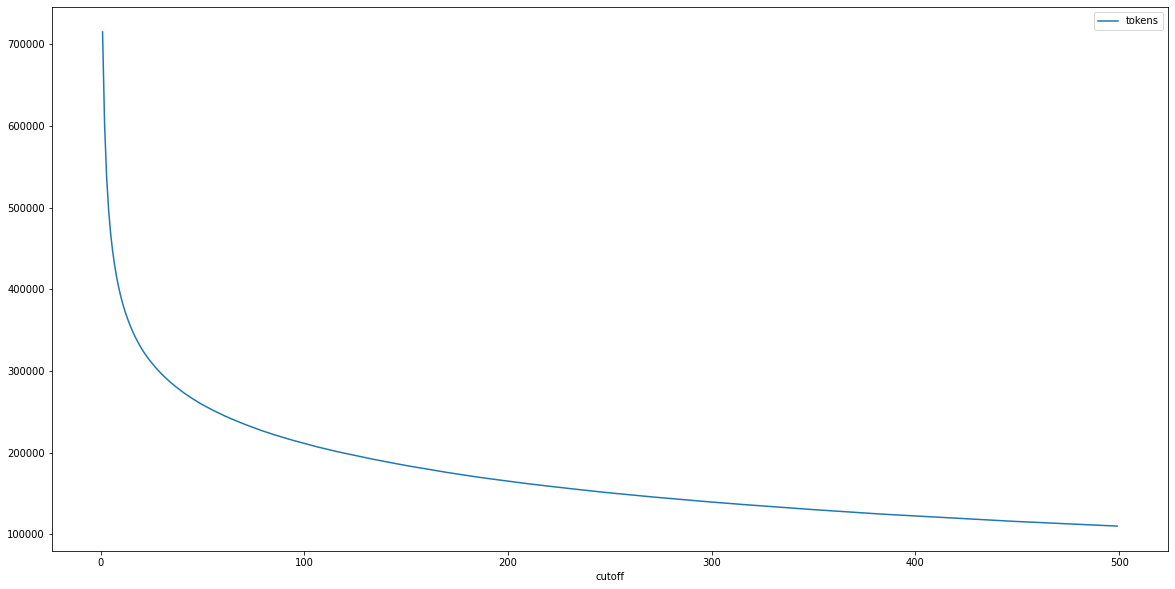

<matplotlib.axes._subplots.AxesSubplot at 0x7fa52d9f64f0>

Out[56]:

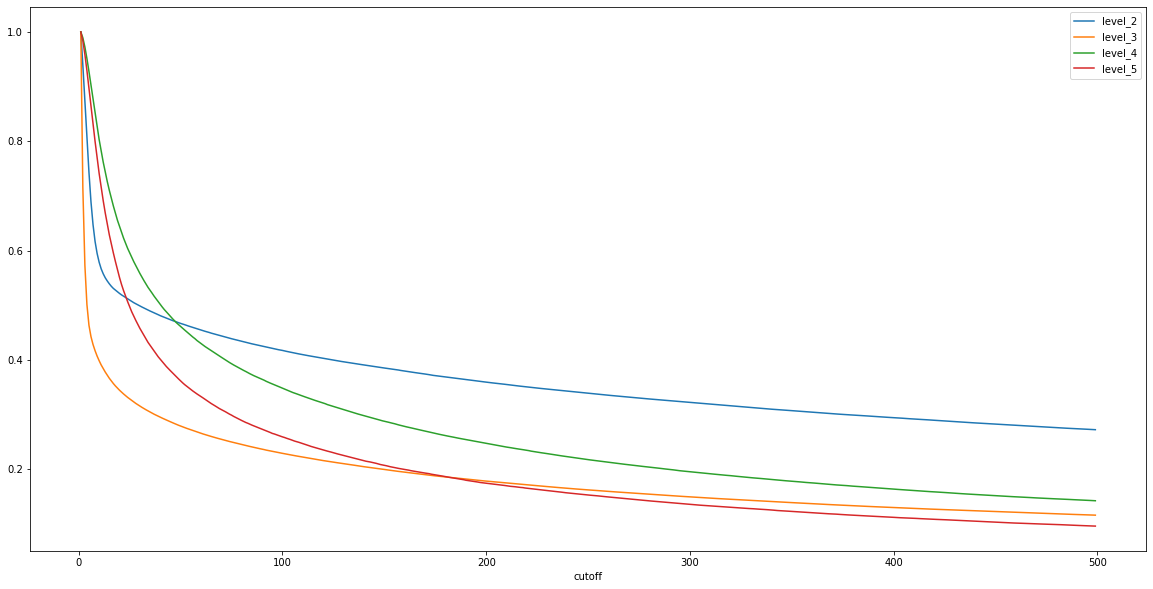

<matplotlib.axes._subplots.AxesSubplot at 0x7fa4fc985c10>

In [0]:
final_df.set_index('cutoff')[['level_2', 'level_3', 'level_4', 'level_5']].plot(figsize=(20,10))